本章研究DEM误差与定位误差之间的关系

In [3]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from functions.dem import WorldDEM, Egm, wgs2utm, utm2wgs, Coord,DEM,SRTM
from functions.image import TX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from copy import copy
from glob import glob
import seaborn as sns

<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_34972/557089927.py:52: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta s_{ele}$(m)")
/tmp/ipykernel_34972/557089927.py:66: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$|\Delta s_{sle}|$(m)")


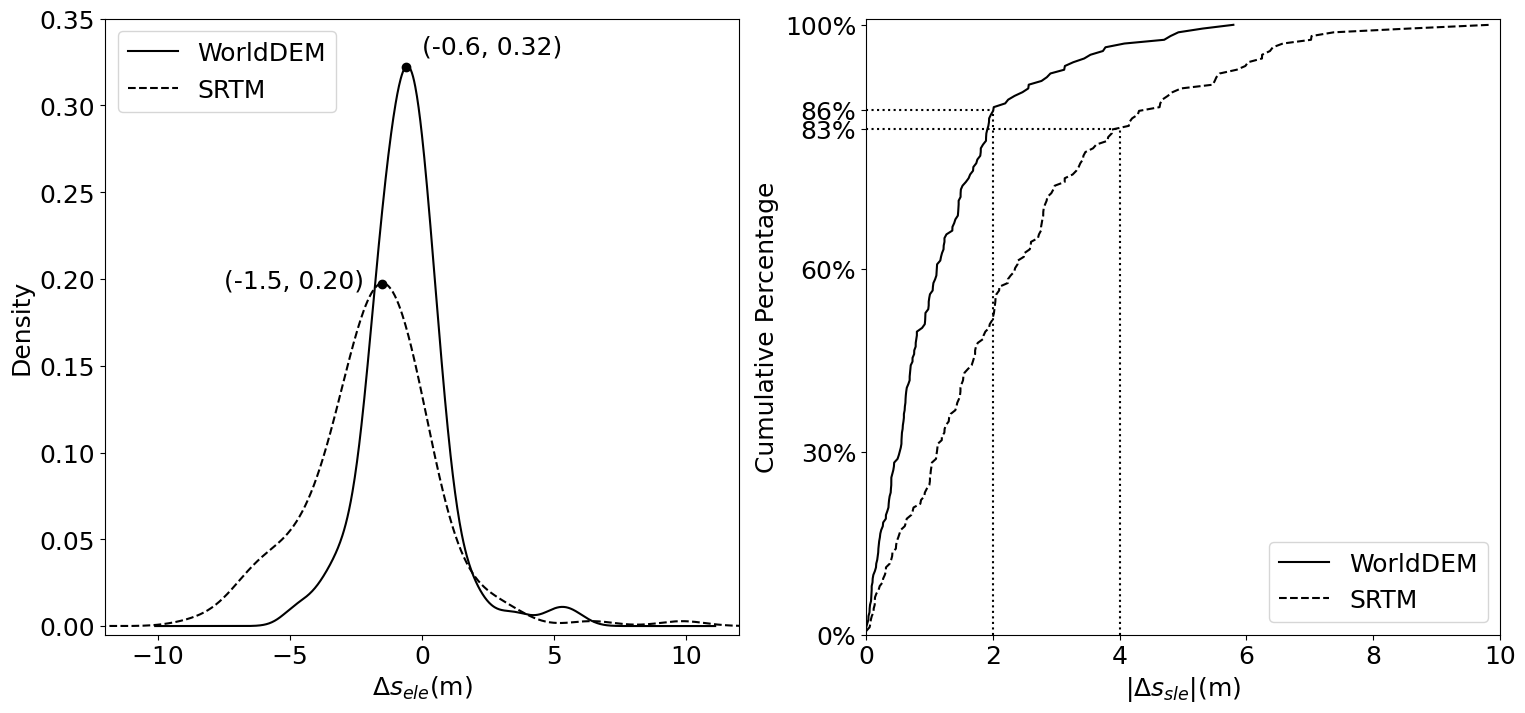

In [4]:
csv_path = "data/points.csv"
egm96_path = "data/EGM/EGM96.tif"
egm2008_path = "data/EGM/EGM2008.tif"
srtm_path = "data/SRTM/SRTMGL1/N40E116.hgt"
worlddem_path = "data/WorldDEM/SO_000117371_0001_1/WorldDEM_DSM_04_N40_16_E116_20/DEM/WorldDEM_DSM_04_N40_16_E116_20_DEM.tif"

def get_tx_paths():
    xml_paths = glob(
        "data/TerraSAR-X/*/TSX-1.SAR.L1B/*/*SAR__SSC*.xml")
    res = {}
    for i in xml_paths:
        filename = i.split("/")[-1][:-4]
        res[filename[28:36]] = ((i, glob(
            "data/TerraSAR-X/*/TSX-1.SAR.L1B/%s/IMAGEDATA/*.cos" % filename)[0]))
    return res

def get_points():
    ps = pd.read_csv(csv_path)
    return ps['lon'],ps['lat'], ps['h']

def geolocate_func():
    xml_path, cos_path = get_tx_paths()['20190117']
    img = TX(xml_path, cos_path)
    return lambda lon, lat, h : img.indirect(lon, lat, h)[1]

def compare_dems():
    lon, lat, h = get_points()
    worlddem = WorldDEM(worlddem_path, Egm(egm2008_path))
    srtm = SRTM(srtm_path, Egm(egm96_path))
    f = geolocate_func()
    cols = f(lon, lat, h)
    cols2 = f(lon, lat, worlddem.find(lon, lat, Coord.WGS84))
    dw = (cols2-cols) *0.9
    cols2 = f(lon, lat, srtm.find(lon, lat, Coord.WGS84))
    ds = (cols2-cols) *0.9

    plt.figure(figsize=(18,8))
    plt.rcParams.update({"font.size": 18})
    plt.subplot(1,2,1)
    pd.Series(np.sort(dw)).plot(kind="kde",label="WorldDEM",c="black", linestyle="solid")
    pd.Series(np.sort(ds)).plot(kind="kde",label="SRTM",c="black", linestyle="dashed")
    # plt.plot((-1.5, -1.5), (-0.005, 0.195),c="black", linestyle="dotted")
    # plt.plot((-0.6, -0.6), (-0.005, 0.32),c="black", linestyle="dotted")
    plt.scatter((-0.6, -1.5),(0.322,0.197),c="black")
    plt.annotate("(-1.5, 0.20)",(-7.5, 0.195))
    plt.annotate("(-0.6, 0.32)",(0, 0.33))
    plt.xlim(-12,12)
    plt.xticks((-10, -5, 0, 5, 10))
    plt.ylim(-0.005, 0.35)
    
    # plt.xlabel("Location residual(m)")
    plt.xlabel("$\Delta s_{ele}$(m)")
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    n = len(dw)
    plt.plot(np.sort(np.abs(dw)),[i/n for i in range(1,n+1)], label="WorldDEM",c="black", linestyle="solid")
    plt.plot(np.sort(np.abs(ds)),[i/n for i in range(1,n+1)], label="SRTM",c="black", linestyle="dashed")
    plt.plot((2,2),(0,0.86),c="black", linestyle="dotted")
    plt.plot((0,2),(0.86,0.86),c="black", linestyle="dotted")
    plt.plot((4,4),(0,0.83),c="black", linestyle="dotted")
    plt.plot((0,4),(0.83,0.83),c="black", linestyle="dotted")
    plt.xlim(0, 10)
    plt.ylim(0, 1.01)
    # plt.xlabel("Location residual(m)")
    plt.xlabel("$|\Delta s_{sle}|$(m)")
    plt.ylabel("Cumulative Percentage")
    plt.yticks((0,0.3,0.6,0.83,0.86,1))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()

    # plt.tight_layout()
    plt.show()

compare_dems()

与坡度之间的关系，因为richdem在高版本python上装不了，所以下述代码未经验证

In [ ]:
import richdem as rd

def get_slope(dem, resolution):
    return rd.TerrainAttribute(rd.rdarray(dem, no_data=-9999), attrib='slope_riserun') / resolution

def compare_with_slope(step=25):
    # linestyles = ("solid", "dotted", "dashed", (0,(5,10)))
    lon, lat, h = get_points()
    worlddem = WorldDEM(worlddem_path, Egm(egm2008_path))
    srtm = SRTM(srtm_path, Egm(egm96_path))
    s = copy(worlddem)
    s.data = get_slope(worlddem.data, 12)
    f = geolocate_func()
    labels = ["[%d%%, %d%%)" % (i, i+step) for i in range(0,99,step)]
    labels[-1] = labels[-1][:-1] + "]"

    slope = s.find(lon, lat, Coord.WGS84)
    delta = f(lon, lat, worlddem.find(lon, lat, Coord.WGS84)) - f(lon, lat, h)
    delta *= 0.9
    res = [delta[(np.nanpercentile(slope, i) <= slope) & (slope < np.nanpercentile(slope, i+step))] for i in range(0, 99, step)]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size": 18})
    plt.subplot(1,2,1)
    for i,j in enumerate(res):
        sns.kdeplot(j, label=labels[i])#, c="black", linestyle=linestyles[i])
    plt.xlim(-7,8)
    plt.ylim(-0.005, 0.55)
    plt.xlabel("$\Delta s_{sle}$(m)")
    plt.legend(prop={'size': 15})

    plt.subplot(1,2,2)
    # lon, lat = getExtent()
    # slope = s.find(lon, lat, Coord.WGS84)
    delta = f(lon, lat, srtm.find(lon, lat, Coord.WGS84)) - f(lon, lat, h)
    delta *= 0.9
    res = [delta[(np.nanpercentile(slope, i) <= slope) & (slope < np.nanpercentile(slope, i+step))] for i in range(0, 99, step)]

    for i,j in enumerate(res):
        sns.kdeplot(j, label=labels[i])#, c="black", linestyle=linestyles[i])
    plt.xlim(-12,13)
    plt.ylim(-0.005, 0.25)
    plt.xlabel("$\Delta s_{sle}$(m)")
    plt.legend(prop={'size': 15})
    plt.show()


compare_with_slope()